# Landsat Satellite Data Gap Filling

This notebook contains code and documentation for correcting data gaps (0-values) in mosaiced Landsat satellite data. 
The data gaps are most apparent in Landsat-5 seamlines.
My approach was: for each 0-data pixel, sample spectral information from adjacent seasons/timesteps in the Landsat data and "fill in" the data gaps.
For example, we have mosaic Landsat data from three seasons: March/April, May/June, and July/August - for three years. If there was missing pixel data from March/April in year 1, I took the mean of the March/April year 2 and year 3 values to fill in the missing data. This was done for each pixel in the tile.

In [ ]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt


timeseries_tiles = ['/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1986_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1989_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1992_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1995_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1998_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2001_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2004_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2007_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2010_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2014_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2016_tile_125_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2019_tile_125_.tif']

stacked_array = np.empty((3715, 3712, 63 * len(timeseries_tiles)), dtype=np.float32)

for i, each_file in enumerate(timeseries_tiles):
    # Open the file, read in as an array
    with rio.open(each_file) as src:
        arr = src.read()
        shp = arr.shape
        print(shp)
        
        # Reshape the input array to match the desired dimensions
        reshaped_arr = np.moveaxis(arr, 0, -1)
        print(reshaped_arr.shape)  # (3715, 3712, 63)
        
        # Stack the arrays along the third axis
        stacked_array[:, :, i * 63:(i + 1) * 63] = reshaped_arr

print(stacked_array.shape)  # (3715, 3712, 756)

print("Done")


# Gap Filling 0s by Mean Value per Band

In [ ]:

# Define the pixel coordinates
pixel_coordinates = (12, 15)

# Extract pixel values for each spectral band
blue_bands = stacked_array[pixel_coordinates[0], pixel_coordinates[1], ::7]
green_bands = stacked_array[pixel_coordinates[0], pixel_coordinates[1], 1::7]
red_bands = stacked_array[pixel_coordinates[0], pixel_coordinates[1], 2::7]
NIR_bands = stacked_array[pixel_coordinates[0], pixel_coordinates[1], 3::7]
SWIR1_bands = stacked_array[pixel_coordinates[0], pixel_coordinates[1], 4::7]
SWIR2_bands = stacked_array[pixel_coordinates[0], pixel_coordinates[1], 5::7]
NDVI_bands = stacked_array[pixel_coordinates[0], pixel_coordinates[1], 6::7]

# Plot the pixel values
x = range(108)
plt.plot(x, blue_bands, label='Blue')
plt.plot(x, green_bands, label='Green')
plt.plot(x, red_bands, label='Red')
plt.plot(x, NIR_bands, label='NIR')
plt.plot(x, SWIR1_bands, label='SWIR1')
plt.plot(x, SWIR2_bands, label='SWIR2')
plt.plot(x, NDVI_bands, label='NDVI')
plt.xlabel('Year')
plt.ylabel('Pixel Value')
plt.title('Pixel Values for Different Spectral Bands')
plt.legend()
plt.show()


# Replace zero values with the mean of other spectral bands
blue_bands[blue_bands == 0] = np.mean(blue_bands[blue_bands != 0])
green_bands[green_bands == 0] = np.mean(green_bands[green_bands != 0])
red_bands[red_bands == 0] = np.mean(red_bands[red_bands != 0])
NIR_bands[NIR_bands == 0] = np.mean(NIR_bands[NIR_bands != 0])
SWIR1_bands[SWIR1_bands == 0] = np.mean(SWIR1_bands[SWIR1_bands != 0])
SWIR2_bands[SWIR2_bands == 0] = np.mean(SWIR2_bands[SWIR2_bands != 0])
NDVI_bands[NDVI_bands == 0] = np.mean(NDVI_bands[NDVI_bands != 0])

# Plot the pixel values
x = range(108)
plt.plot(x, blue_bands, label='Blue')
plt.plot(x, green_bands, label='Green')
plt.plot(x, red_bands, label='Red')
plt.plot(x, NIR_bands, label='NIR')
plt.plot(x, SWIR1_bands, label='SWIR1')
plt.plot(x, SWIR2_bands, label='SWIR2')
plt.plot(x, NDVI_bands, label='NDVI')
plt.xlabel('Year')
plt.ylabel('Pixel Value')
plt.title('Pixel Values for Different Spectral Bands')
plt.legend()
plt.show()

# Gap Fill one Tile

In [ ]:
import rasterio as rio
import numpy as np

timeseries_tiles = ['/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1986_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1989_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1992_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1995_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_1998_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2001_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2004_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2007_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2010_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2014_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2016_tile_211_.tif',
                    '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/landsat_image_temporalcnn_2019_tile_211_.tif']


# Empty array to hold stack of Landsat tiles
stacked_array = None

for i, each_file in enumerate(timeseries_tiles):
    # Open the file, read in as an array
    with rio.open(each_file) as src:
        arr = src.read()
        shp = arr.shape
        print(shp)
        print(f"Read File: {each_file}")

        # Reshape the input array to match the desired dimensions
        reshaped_arr = np.moveaxis(arr, 0, -1)

        if stacked_array is None:
            # Create the stacked array on the first iteration
            stacked_array = np.empty((shp[1], shp[2], 63 * len(timeseries_tiles)), dtype=np.float32)

        # Stack the arrays along the third axis
        stacked_array[:, :, i * 63:(i + 1) * 63] = reshaped_arr

print(stacked_array.shape)  # (3715, 3712, 756)

# Iterate over each pixel
for row in range(stacked_array.shape[0]):
    print(f"Processed row: {row+1}/{stacked_array.shape[0]}")
    for col in range(stacked_array.shape[1]):
        # Extract pixel values for each spectral band
        blue_bands = stacked_array[row, col, ::7]
        green_bands = stacked_array[row, col, 1::7]
        red_bands = stacked_array[row, col, 2::7]
        NIR_bands = stacked_array[row, col, 3::7]
        SWIR1_bands = stacked_array[row, col, 4::7]
        SWIR2_bands = stacked_array[row, col, 5::7]
        NDVI_bands = stacked_array[row, col, 6::7]

        # Replace zero values with the mean of other spectral bands
        blue_bands[blue_bands == 0] = np.mean(blue_bands[blue_bands != 0])
        green_bands[green_bands == 0] = np.mean(green_bands[green_bands != 0])
        red_bands[red_bands == 0] = np.mean(red_bands[red_bands != 0])
        NIR_bands[NIR_bands == 0] = np.mean(NIR_bands[NIR_bands != 0])
        SWIR1_bands[SWIR1_bands == 0] = np.mean(SWIR1_bands[SWIR1_bands != 0])
        SWIR2_bands[SWIR2_bands == 0] = np.mean(SWIR2_bands[SWIR2_bands != 0])
        NDVI_bands[NDVI_bands == 0] = np.mean(NDVI_bands[NDVI_bands != 0])

        # Assign the modified values back to the original array
        stacked_array[row, col, ::7] = blue_bands
        stacked_array[row, col, 1::7] = green_bands
        stacked_array[row, col, 2::7] = red_bands
        stacked_array[row, col, 3::7] = NIR_bands
        stacked_array[row, col, 4::7] = SWIR1_bands
        stacked_array[row, col, 5::7] = SWIR2_bands
        stacked_array[row, col, 6::7] = NDVI_bands

        

print("Done")      
        
#Save raster with rasterio using same metadata as for import
        
        
        

In [ ]:
print(stacked_array.shape)

In [ ]:
import rasterio as rio
from rasterio.transform import from_origin

tile211_timeseries_arr_out = '/home/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/tile211_mean_corrected_may1823.tif'

# Output metadata
out_meta = src.meta.copy()

# Calculate the new transform to ensure the same resolution as the source data
out_transform = from_origin(src.bounds.left, src.bounds.top, src.res[0], src.res[1]) 

# Update output metadata to specify a single band and the new transform
out_meta.update({'driver': 'GTiff',
                 'count': stacked_array.shape[2],
                 'width': stacked_array.shape[1],
                 'height': stacked_array.shape[0],
                 'dtype': stacked_array.dtype,
                 'crs': src.crs,
                 'transform': out_transform})

# Write all bands to the same raster file
with rio.Env(CHECK_DISK_FREE_SPACE=False):
    with rio.open(tile211_timeseries_arr_out, mode='w', **out_meta) as dst:
        for i in range(stacked_array.shape[2]):
            dst.write(stacked_array[:, :, i], i + 1)







In [ ]:
#plt.imshow(stacked_array[:, :, 6])
plt.imshow(stacked_array[:, :, 3])
#plt.imshow(stacked_array[:, :, 6])
#plt.imshow(stacked_array[:, :, 6])



# Now with the gap filled Landsat images, load model for prediction

In [3]:
# Keras setup.
import keras

# Load a trained model
model = keras.models.load_model(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/temporalCNN/Archi3/TemporalCNN_300epochs_latlongenc_dropout_uncertainty_topmodel_apr122023.h5')

model.summary()




2023-05-19 13:21:50.433994: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-19 13:22:05.057248: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-19 13:22:05.094168: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-19 13:22:07.237337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla K40m computeCapability: 3.5
coreClock: 0.745GHz coreCount: 15 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 268.58GiB/s
2023-05-19 13:22:07.237403: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-19 13:22:07.494597: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-19

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 9, 7)]       0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 9, 32)        704         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 9, 32)        128         conv1d_9[0][0]                   
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 9, 32)        0           batch_normalization_12[0][0]     
___________________________________________________________________________________________

# Model Prediction Across Time-Steps 

Read File
(500, 500)
Got Coordinates of Landsat Image 

         lat         lon   data
0  45.905842 -100.975983  709.0
1  45.905842 -100.975713  690.0
2  45.905842 -100.975444  690.0
3  45.905842 -100.975174  727.0
4  45.905842 -100.974905  672.0
(756, 500, 500)
Processing subset with bands: 0 - 63
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data



2023-05-19 13:22:47.006861: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-19 13:22:47.007610: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2497360000 Hz
2023-05-19 13:22:47.319056: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-19 13:22:48.082659: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-05-19 13:22:51.484811: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-05-19 13:22:51.529559: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


(500, 500)


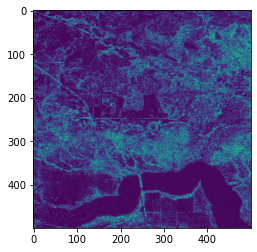

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_0-63.tif
30.59
Processing subset with bands: 21 - 84
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


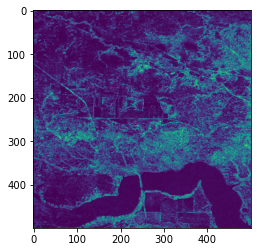

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_21-84.tif
39.35
Processing subset with bands: 42 - 105
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


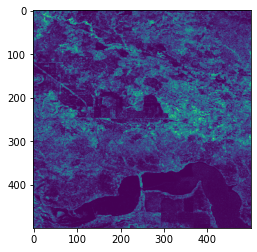

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_42-105.tif
48.32
Processing subset with bands: 63 - 126
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


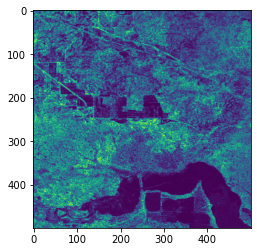

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_63-126.tif
57.03
Processing subset with bands: 84 - 147
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


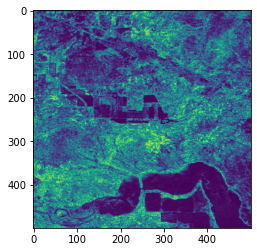

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_84-147.tif
65.98
Processing subset with bands: 105 - 168
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


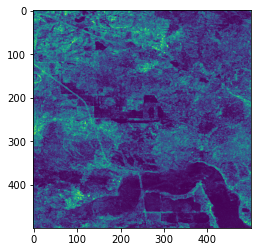

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_105-168.tif
74.88
Processing subset with bands: 126 - 189
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


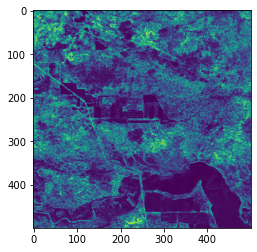

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_126-189.tif
83.7
Processing subset with bands: 147 - 210
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


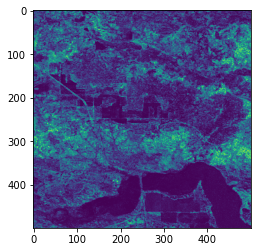

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_147-210.tif
92.7
Processing subset with bands: 168 - 231
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


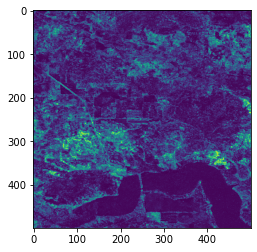

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_168-231.tif
101.49
Processing subset with bands: 189 - 252
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


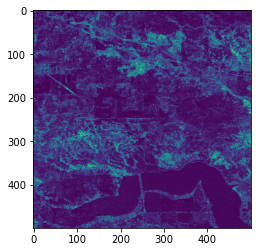

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_189-252.tif
110.54
Processing subset with bands: 210 - 273
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


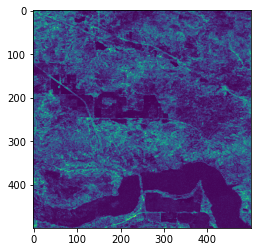

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_210-273.tif
119.3
Processing subset with bands: 231 - 294
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


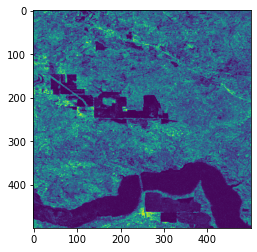

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_231-294.tif
128.09
Processing subset with bands: 252 - 315
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


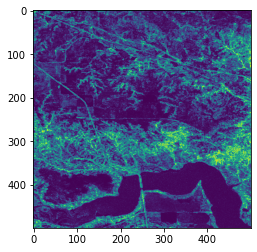

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_252-315.tif
136.82
Processing subset with bands: 273 - 336
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


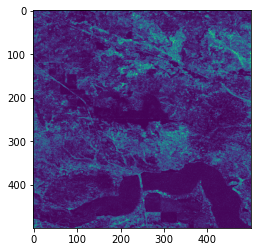

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_273-336.tif
145.58
Processing subset with bands: 294 - 357
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


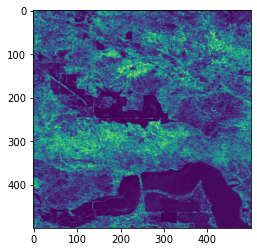

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_294-357.tif
154.46
Processing subset with bands: 315 - 378
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


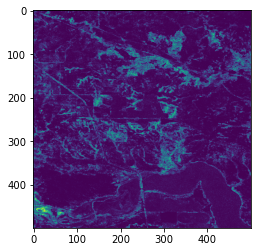

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_315-378.tif
163.26
Processing subset with bands: 336 - 399
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


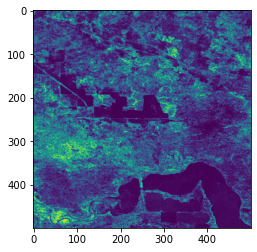

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_336-399.tif
172.03
Processing subset with bands: 357 - 420
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


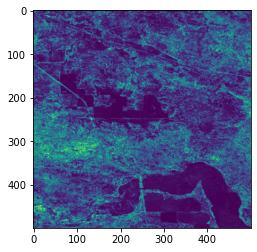

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_357-420.tif
181.02
Processing subset with bands: 378 - 441
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


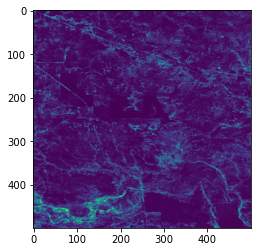

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_378-441.tif
189.72
Processing subset with bands: 399 - 462
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


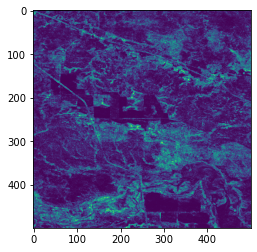

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_399-462.tif
198.39
Processing subset with bands: 420 - 483
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


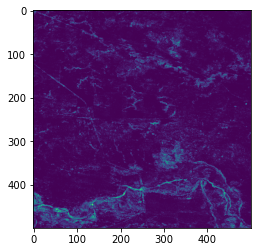

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_420-483.tif
207.03
Processing subset with bands: 441 - 504
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


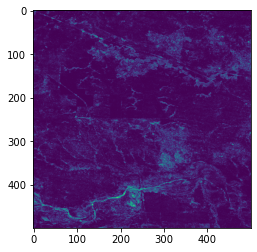

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_441-504.tif
215.8
Processing subset with bands: 462 - 525
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


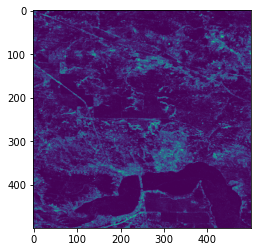

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_462-525.tif
224.67
Processing subset with bands: 483 - 546
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


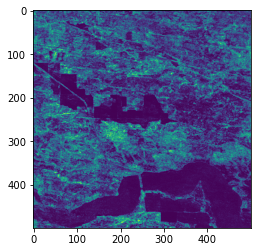

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_483-546.tif
233.44
Processing subset with bands: 504 - 567
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


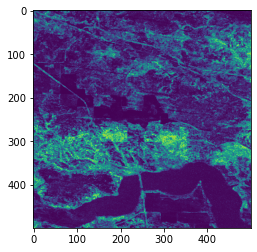

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_504-567.tif
242.15
Processing subset with bands: 525 - 588
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


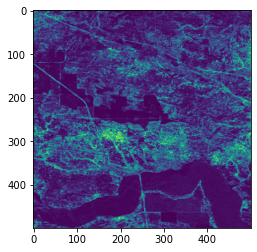

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_525-588.tif
250.78
Processing subset with bands: 546 - 609
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


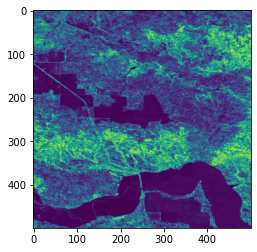

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_546-609.tif
259.7
Processing subset with bands: 567 - 630
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


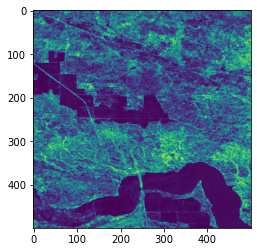

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_567-630.tif
268.39
Processing subset with bands: 588 - 651
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


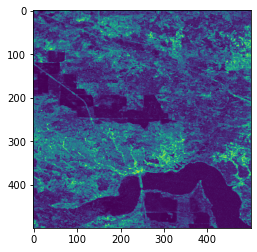

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_588-651.tif
277.24
Processing subset with bands: 609 - 672
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


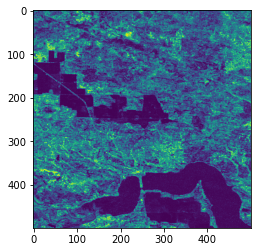

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_609-672.tif
285.92
Processing subset with bands: 630 - 693
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


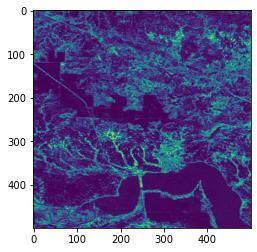

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_630-693.tif
294.68
Processing subset with bands: 651 - 714
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


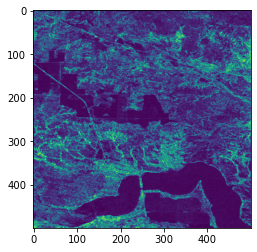

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_651-714.tif
303.41
Processing subset with bands: 672 - 735
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


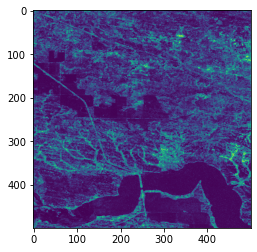

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_672-735.tif
312.12
Processing subset with bands: 693 - 756
(63, 500, 500)
500 500
(250000, 9, 7)
Got Spectral Data

(500, 500)


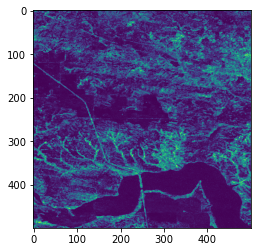

Writing file tile211_mini_gapcorrected_spurge_tiny_yearly_693-756.tif
320.83
Processing subset with bands: 714 - 777
(42, 500, 500)
500 500


ValueError: cannot reshape array of size 10500000 into shape (250000,9,7)

In [4]:
#Model Prediction

import rasterio as rio
from rasterio.plot import show
import glob
import time
import itertools
from itertools import tee
import os

# Input prediction .tif path
image_path = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/tile211_tiny_mean_corrected_may1823.tif'

# Output prediction file path
outpath = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection'

# List all .tif files in /rasters folder for prediction
#tif_image_list = glob.glob(image_path + '*.tif')
#print(tif_image_list[0])

prediction_train_time = time.time()


with rio.open(image_path, 'r') as dataset:
    # First, get the coordinates of every pixel in the .tif image
    print("Read File")
    shape = dataset.shape
    nodata = dataset.nodata
    print(shape)

    # Get the X, Y coordinates (latitude/longitude) for each pixel
    coords = np.empty((shape[0] * shape[1], 2), dtype=np.float64)
    coords[:, 0], coords[:, 1] = dataset.xy(np.repeat(np.arange(shape[0]), shape[1]), np.tile(np.arange(shape[1]), shape[0]))

    # Retrieve the data for each pixel
    data = dataset.read(1).flatten()

    # Filter out pixels with nodata values
    valid_pixels = data != nodata
    coords = coords[valid_pixels]
    data = data[valid_pixels]
    
    coords2 = coords[:,0:2] # Remove 'data' column, make latitude come before longitude
    coords2[:,[1,0]] = coords2[:,[0,1]] # swap longitude and latitude columns
    #print(coords2[1:10, :], coords2.shape)
    print("Got Coordinates of Landsat Image \n")

    # Create a DataFrame with latitude, longitude, and data values
    res = pd.DataFrame({"lat": coords[:, 0], "lon": coords[:, 1], "data": data})

    print(res.head())
    
    # Second, get the spectral data from every pixel in the .tif image
    arr = dataset.read()
    
    bands, width, height = arr.shape
    print(arr.shape)
    
    # Convert Tif Data Type to float32 by division.
    arr = arr/10000
    
    # Loop to process every subset of 63 bands, increasing by 21 bands
    for i in range(0, arr.shape[0], 63):
        subset = arr[i:i+63, :, :]
        print("Processing subset with bands:", i, "-", i+63)
        print(subset.shape)

        # Reshape .tif array axes for correct format so the model can predict
        subset = np.moveaxis(subset, 0, -1)  # move axis to channels last
        new_arr = subset.reshape(-1, subset.shape[-1])  # reshape to row and column
        print(width, height)
        num_pixels = width * height
        spectral = new_arr.reshape(num_pixels, 9, 7)
        print(spectral.shape)

        #combine both latitude/longitude and spectral data into list for model prediction
        X_pred = [coords2, spectral]
        print("Got Spectral Data\n")

        # Predict model and reshape to export.
        p = model.predict(X_pred) # p is prediction from the DL model
        pim = p.reshape(width, height, 10) # Dimension of prediction in rows, columns, bands (10 classes)
        pim2 = np.moveaxis(pim, 2, 0) # move axis so bands is first

        # ArgMax for Segmentation.
        pim3 = np.argmax(pim2, axis=0) # take softmax of predictions for segmentation
        print(pim3.shape)
        
        plt.imshow(pim[..., 9])
        plt.savefig(os.path.join(outpath, f"subset_mini_{i}-{i+63}.png"))

        plt.show()
        
        # Get the file name (landsat_image_170_t.tif) by splitting input path.
        fileout_string = f"tile211_mini_gapcorrected_spurge_tiny_yearly_{i}-{i+63}.tif"

        # Output prediction raster .
        out_meta = dataset.meta.copy()

        # Calculate the new transform with offsets to align with the input data
        out_transform = rio.transform.from_origin(dataset.bounds.left + 1000, dataset.bounds.top - 500, dataset.res[0], dataset.res[1])

        # Update output metadata with the new transform
        out_meta.update({'driver': 'GTiff',
                         'width': subset.shape[1],
                         'height': subset.shape[0],
                         'count': 1,
                         'dtype': 'float64',
                         'crs': dataset.crs,
                         'transform': out_transform,
                         'nodata': 0})


        # Write predicted raster to file.
        with rio.open(fp=os.path.join(outpath, "prediction_" + fileout_string), mode='w', **out_meta) as dst:
            dst.write(pim[:, :, 9], 1) # to export one layer, write individual bands
            #dst.write(pim3, 1) # the number one is the number of bands

        print(f"Writing file {fileout_string}")
        prediction_time = round(time.time()-prediction_train_time, 2)
        print(prediction_time)


# Save time-series of png images predictions as an animated-gif

In [3]:
#Save tiles as png images
import os
import imageio
from PIL import Image

# Directory containing the PNG images
image_directory = r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/tile211_spurge_pred_corrected_png/'

# Output directory and file name for the animated GIF
output_directory =  r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/tile211_spurge_pred_corrected_png/'
gif_filename = 'animated.gif'

png_files = glob.glob(image_directory + '*.png')

# Sort the list of PNG files in increasing order
sorted_png_files = sorted(png_files, key=lambda x: int(x.split("_")[-1].split("-")[0]))

# Update the png_files variable with the sorted list
png_files = sorted_png_files

print(png_files)


# Create the animated GIF using imageio
with imageio.get_writer(os.path.join(output_directory, gif_filename), mode='I') as writer:
    for png_file in png_files:
        image_path = os.path.join(image_directory, png_file)
        image = Image.open(image_path)
        image_array = np.array(image)
        writer.append_data(image_array)

print(f"Animated GIF saved as {os.path.join(output_directory, gif_filename)}")



['/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/tile211_spurge_pred_corrected_png/subset_0-63.png', '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/tile211_spurge_pred_corrected_png/subset_21-84.png', '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/tile211_spurge_pred_corrected_png/subset_42-105.png', '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/tile211_spurge_pred_corrected_png/subset_63-126.png', '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/tile211_spurge_pred_corrected_png/subset_84-147.png', '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/landsat_tifs_tile211_timeseries_imagecorrection/tile211_spurge_pred_corrected_png/subset_105-168.png', '/panfs/jay/groups/31/m


# Plotting and analyses of Intercept, slope, growth rate, carrying capacity, r_squared predictions

(250000,)

(250000,)

(250000,)

(250000,)

(250000,)

Text(0.5, 1.0, 'Intercepts')

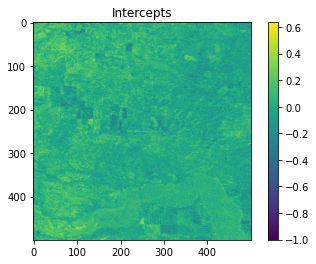

Text(0.5, 1.0, 'Slopes')

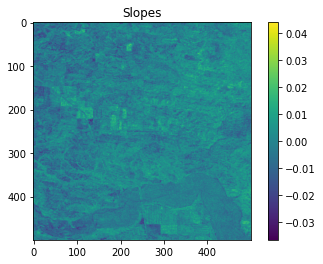

Text(0.5, 1.0, 'R Squared Values')

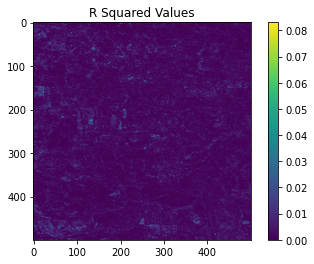

Text(0.5, 1.0, 'Growth Rates')

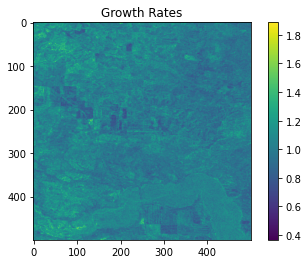

Text(0.5, 1.0, 'Carrying Capacities')

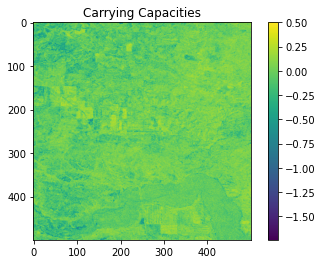

In [41]:

# Convert lists to NumPy arrays
intercepts_arr = np.array(result[..., 0]) #shape (51238815,)
slopes_arr = np.array(result[..., 1])
growths_arr = np.array(result[..., 2])
capacities_arr = np.array(result[..., 3])
r_squared_arr = np.array(result[..., 4])

intercepts_arr.shape
slopes_arr.shape
growths_arr.shape
capacities_arr.shape
r_squared_arr.shape

# Reshape arrays to match the dimensions of the input map
intercepts_arr = intercepts_arr.reshape((500, 500))
slopes_arr = slopes_arr.reshape((500, 500))
growths_arr = growths_arr.reshape((500, 500))
capacities_arr = capacities_arr.reshape((500, 500))
r_squared_arr = r_squared_arr.reshape((500, 500))


# Plotting the intercepts
plt.imshow(intercepts_arr)
plt.colorbar()
plt.title("Intercepts")
plt.show()

# Plotting the slopes
plt.imshow(slopes_arr)
plt.colorbar()
plt.title("Slopes")
plt.show()

# Plotting the carrying capacities
plt.imshow(r_squared_arr)
plt.colorbar()
plt.title("R Squared Values")
plt.show()

# Plotting the growth rates
plt.imshow(growths_arr)
plt.colorbar()
plt.title("Growth Rates")
plt.show()

# Plotting the carrying capacities
plt.imshow(capacities_arr)
plt.colorbar()
plt.title("Carrying Capacities")
plt.show()



